# Goal

* Analyze results from `atomIncorp_sampDepth` simulation

# Var

In [374]:
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth/'

# Init

In [375]:
library(dplyr)
library(tidyr)
library(ggplot2)

In [376]:
# classifying true positives, neg, ...
clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

# Load

In [377]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='*-cMtx_byClass.txt', full.names=TRUE)
files

[1] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//DESeq2_multi-cMtx_byClass.txt"
[2] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//DESeq2-cMtx_byClass.txt"      
[3] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//heavy-cMtx_byClass.txt"       
[4] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//qSIP-cMtx_byClass.txt"

In [378]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

,library,variables,values,percIncorp,subsample_size,rep,file,method
1,2,Sensitivity,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,1,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [379]:
# renaming methods
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'q-SIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

,library,variables,values,percIncorp,subsample_size,rep,file,method
1,2,Sensitivity,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,1,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Pos Pred Value,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


# Incorp-call accuracy

Warning message:
“Removed 64 rows containing missing values (geom_pointrange).”

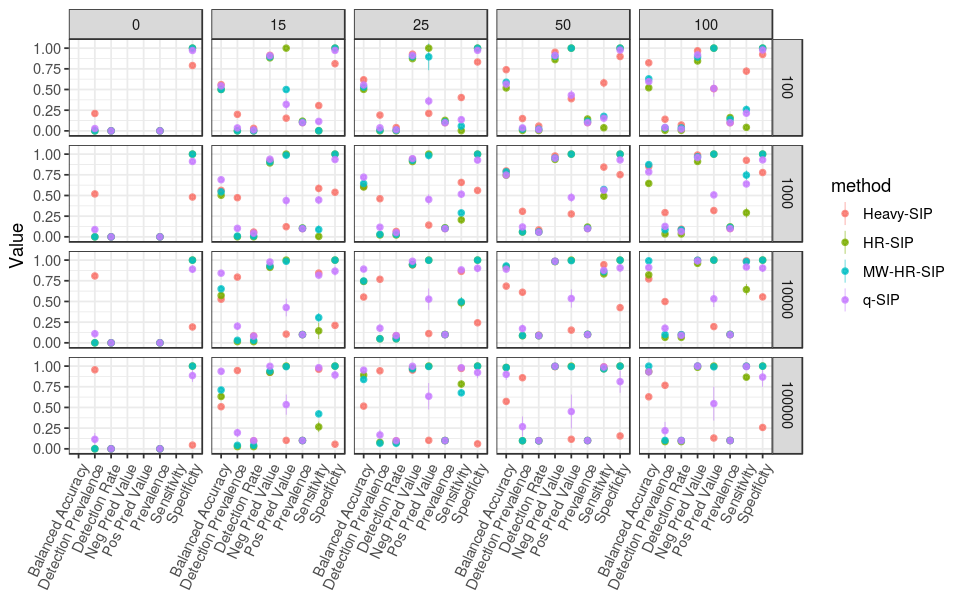

In [380]:
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, subsample_size, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
options(repr.plot.width=8, repr.plot.height=5)
p = ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(subsample_size ~ percIncorp) +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=65, hjust=1)
    )
plot(p)

Warning message:
“Removed 32 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_linerange).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

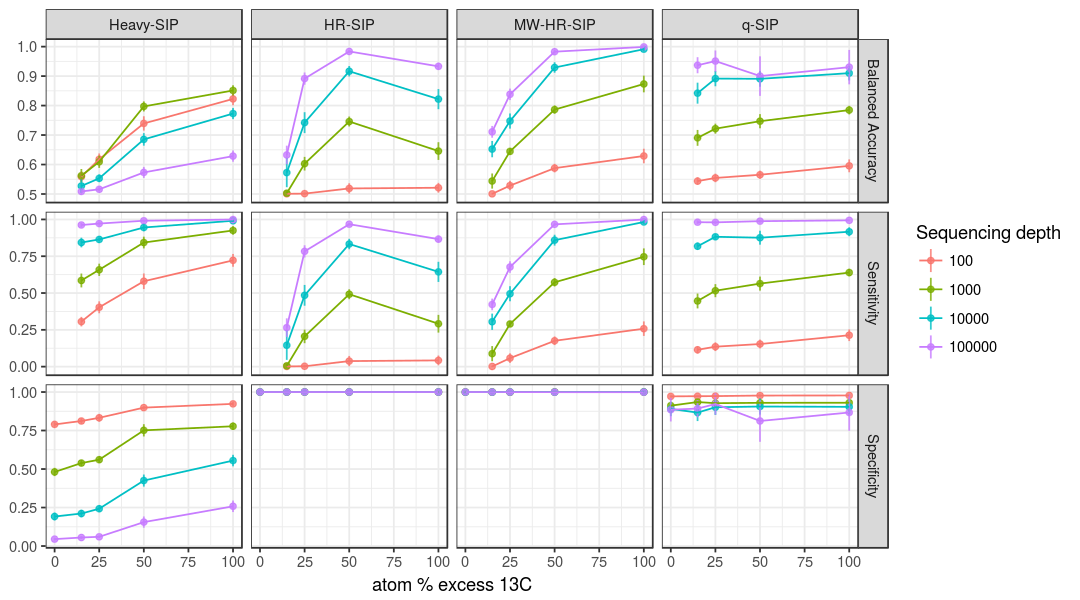

In [381]:
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(subsample_size = subsample_size %>% as.character,
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=subsample_size, 
                           group=subsample_size,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('Sequencing depth') +
    labs(x='atom % excess 13C') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt)

In [382]:
outF = file.path(workDir, 'atomIncorp_sampDepth_acc.pdf')
ggsave(outF, p.pnt, width=10, height=6)
cat('File written:', outF, '\n')

Warning message:
“Removed 32 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_linerange).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//atomIncorp_sampDepth_acc.pdf 


# Sensitivity ~ abundance

* `sensitivity = true_positive / (true_positive + false_negative)`
* `sensitivity = true_incorporators_called_incorporators / (true_incorporators)`

## Load true BD shift

In [383]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 200


In [384]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, subsample_size, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE))

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 220400


,taxon,percIncorp,subsample_size,rep,median_true_BD_shift,true_incorporator
1,Acaryochloris_marina_MBIC11017,0,100,1,0,FALSE
2,Acaryochloris_marina_MBIC11017,0,100,10,0,FALSE
3,Acaryochloris_marina_MBIC11017,0,100,2,0,FALSE


## Loading original taxon abundances

In [385]:
comm_files = list.files(path=workDir, pattern='comm.txt', full.names=TRUE, recursive=TRUE)
comm_files %>% length %>% print

[1] 200


In [386]:
df_comm = list()
for(F in comm_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_comm[[F]] = tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)


# mean abund for libraries
df_comm = df_comm %>%
    rename('taxon' = taxon_name) %>%
    group_by(taxon, percIncorp, subsample_size, rep) %>%
    summarize(mean_rel_abund_perc = mean(rel_abund_perc),
              mean_rank_abund = mean(rank)) %>%
    ungroup()

# status
df_comm %>% nrow %>% print
df_comm %>% head(n=3)

[1] 229400


,taxon,percIncorp,subsample_size,rep,mean_rel_abund_perc,mean_rank_abund
1,Acaryochloris_marina_MBIC11017,0,100,1,0.0285016093333333,380
2,Acaryochloris_marina_MBIC11017,0,100,10,0.0151713453333333,534
3,Acaryochloris_marina_MBIC11017,0,100,2,0.136166018333333,135


## Load MW-HR-SIP incorp tables

In [387]:
MW_files = list.files(path=workDir, pattern='_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
MW_files %>% length %>% print

[1] 200


In [388]:
df_MW = list()
#for(F in MW_files){
for(F in MW_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_MW[[F]] = tmp
}

df_MW = do.call(rbind, df_MW)
rownames(df_MW) = 1:nrow(df_MW)

# status
df_MW %>% nrow %>% print
df_MW %>% head(n=3)

[1] 191661


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,heavy_BD_max,taxon,incorp,percIncorp,subsample_size,rep,file
1,0.0425531914893617,0.000258171652366614,0.170713818686249,0.0015123067034257,0.998793354290086,0.998793354290086,0.928256301406218,0,0,1.7,1.73,Acetobacter_pasteurianus_IFO_3283-03,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2,0.0212765957446809,0.00722299364984618,0.170713818686249,0.0423105388036639,0.966251144060282,0.998793354290086,0.922505541268084,0,0,1.7,1.73,Acholeplasma_laidlawii_PG-8A,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3,0.0638297872340425,0.021758272997478,0.170713818686249,0.12745466749512,0.898580550588063,0.998793354290086,0.909386149408206,0,0,1.7,1.73,Acidaminococcus_intestini_RyC-MR95,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt


## group by abundance and calculate sensitivity

In [389]:
join_vars = c('taxon' = 'taxon',
              'percIncorp'='percIncorp',
              'subsample_size'='subsample_size',
              'rep'='rep')

# joining tables
df_MW %>% nrow %>% print
df.j = df_MW %>% 
    left_join(df_shift, join_vars)

df.j %>% nrow %>% print
df.j = df.j %>% 
    left_join(df_comm, join_vars)

# status
df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 191661


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 191661


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 191661


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,p,occur_all,occur_heavy,heavy_BD_min,⋯,taxon,incorp,percIncorp,subsample_size,rep,file,median_true_BD_shift,true_incorporator,mean_rel_abund_perc,mean_rank_abund
1,0.0425531914893617,0.000258171652366614,0.170713818686249,0.0015123067034257,0.998793354290086,0.998793354290086,0.928256301406218,0,0,1.7,⋯,Acetobacter_pasteurianus_IFO_3283-03,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.0322891888333333,356
2,0.0212765957446809,0.00722299364984618,0.170713818686249,0.0423105388036639,0.966251144060282,0.998793354290086,0.922505541268084,0,0,1.7,⋯,Acholeplasma_laidlawii_PG-8A,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.0025386615,893
3,0.0638297872340425,0.021758272997478,0.170713818686249,0.12745466749512,0.898580550588063,0.998793354290086,0.909386149408206,0,0,1.7,⋯,Acidaminococcus_intestini_RyC-MR95,FALSE,0,100,1,OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt,0,FALSE,0.0265699998333333,395


In [390]:
# calling true_pos + false_neg
df.j = df.j %>%
    mutate(incorp_cls = mapply(clsfy, incorp, true_incorporator)) 

# status

df.j %>% nrow %>% print
df.j$incorp_cls %>% table %>% print

[1] 191661
.
False negative False positive  True negative  True positive 
          7621             65         175537           8438 


In [393]:
# function for calculating sensitivity
calc_sensitivity = function(incorp_cls){
    tp = sum(incorp_cls == 'True positive')
    fn = sum(incorp_cls == 'False negative')
    x = tp / (tp + fn)
    ifelse(is.na(x), 0, x)
}

# grouping by abundance and calculating sensitivity
df.j.s = df.j %>%
    mutate(n_group = ntile(log10(mean_rel_abund_perc), 10)) %>%
    group_by(n_group, percIncorp, subsample_size, rep) %>%
    summarize(min_abund = min(mean_rel_abund_perc, na.rm=TRUE),
              mean_abund = mean(mean_rel_abund_perc, na.rm=TRUE),
              max_abund = max(mean_rel_abund_perc, na.rm=TRUE),
              sensitivity = calc_sensitivity(incorp_cls)) %>%
    group_by(n_group, percIncorp, subsample_size) %>%
    summarize(mean_abund = mean(mean_abund),
              mean_sensitivity = mean(sensitivity),
              sd_sensitivity = sd(sensitivity)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% as.character,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric))

# status
df.j.s %>% head(n=3)

,n_group,percIncorp,subsample_size,mean_abund,mean_sensitivity,sd_sensitivity
1,1,0,100,0.000921090753422593,0,0
2,1,0,1000,0.000868003020951069,0,0
3,1,0,10000,0.000740672275403099,0,0


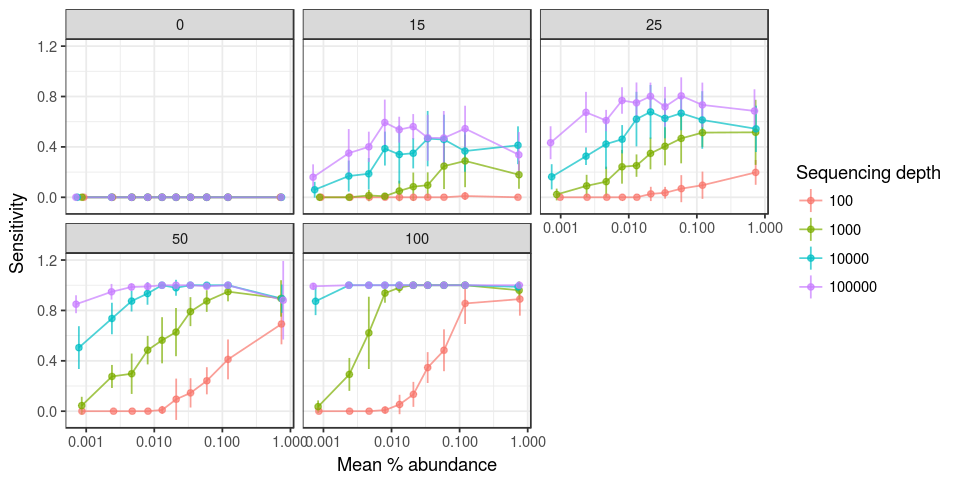

In [396]:
# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_sens_abund = ggplot(df.j.s, aes(mean_abund, mean_sensitivity, 
                                  color=subsample_size, group=subsample_size,
                                  ymin=mean_sensitivity-sd_sensitivity,
                                  ymax=mean_sensitivity+sd_sensitivity)) +
    geom_line(alpha=0.7) +
    geom_linerange(alpha=0.7) +
    geom_point(alpha=0.7) +
    scale_x_log10(breaks=c(1e-3, 1e-2, 1e-1, 1e0)) +
    scale_color_discrete('Sequencing depth') +
    labs(x='Mean % abundance',
         y='Sensitivity') +
    facet_wrap(~ percIncorp) +
    theme_bw()

p_sens_abund

In [397]:
outF = file.path(workDir, 'atomIncorp_sampDepth_sens-abund.pdf')
ggsave(outF, p_sens_abund, width=10, height=5)
cat('File written:', outF, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//atomIncorp_sampDepth_sens-abund.pdf 


# BD shift quantify

## True BD shift

In [398]:
BDshift_files = list.files(path=workDir, pattern='BD-shift_stats.txt', full.names=TRUE, recursive=TRUE)
BDshift_files %>% length %>% print

[1] 200


In [399]:
df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, subsample_size, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median) 

# status
df_shift %>% nrow %>% print
df_shift %>% head(n=3)

[1] 220400


,taxon,percIncorp,subsample_size,rep,median_true_BD_shift
1,Acaryochloris_marina_MBIC11017,0,100,1,0
2,Acaryochloris_marina_MBIC11017,0,100,10,0
3,Acaryochloris_marina_MBIC11017,0,100,2,0


## MW-HR-SIP incorp calls

* filtering BD shift estimates to just incorporators identified by MW-HR-SIP

In [400]:
incorp_files = list.files(path=workDir, pattern='OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt', full.names=TRUE, recursive=TRUE)
incorp_files %>% length %>% print

[1] 200


In [401]:
df_incorp = list()
for(F in incorp_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_incorp[[F]] = tmp
}

df_incorp = do.call(rbind, df_incorp)
rownames(df_incorp) = 1:nrow(df_incorp)
df_incorp %>% head(n=3) %>% print

    baseMean log2FoldChange     lfcSE        stat    pvalue      padj         p
1 0.04255319   0.0002581717 0.1707138 0.001512307 0.9987934 0.9987934 0.9282563
2 0.02127660   0.0072229936 0.1707138 0.042310539 0.9662511 0.9987934 0.9225055
3 0.06382979   0.0217582730 0.1707138 0.127454667 0.8985806 0.9987934 0.9093861
  occur_all occur_heavy heavy_BD_min heavy_BD_max
1         0           0          1.7         1.73
2         0           0          1.7         1.73
3         0           0          1.7         1.73
                                 taxon incorp percIncorp subsample_size rep
1 Acetobacter_pasteurianus_IFO_3283-03  FALSE          0            100   1
2         Acholeplasma_laidlawii_PG-8A  FALSE          0            100   1
3   Acidaminococcus_intestini_RyC-MR95  FALSE          0            100   1
                                          file
1 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
2 OTU_abs1e9_PCR_sub_filt_MW_DESeq2_incorp.txt
3 OTU_abs1e9_PCR_sub_filt_MW_DESeq2

In [402]:
# just incorporators
df_incorp = df_incorp %>%
    filter(incorp == TRUE) %>%
    dplyr::distinct(taxon, incorp, percIncorp, subsample_size, rep) %>%
    rename('HWHRSIP_incorp' = incorp)

df_incorp %>% nrow %>% print
df_incorp %>% head(n=3) %>% print

[1] 8503
                                taxon HWHRSIP_incorp percIncorp subsample_size
1     Citrobacter_koseri_ATCC_BAA-895           TRUE          0            100
2     Enterococcus_casseliflavus_EC20           TRUE          0           1000
3 Xanthomonas_translucens_pv_undulosa           TRUE          0           1000
  rep
1   4
2   4
3   4


## q-SIP

In [403]:
atomX_files = list.files(path=workDir, pattern='*_qSIP_atom.txt', full.names=TRUE, recursive=TRUE)
atomX_files %>% length %>% print

[1] 200


In [404]:
df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3) %>% print

                                 taxon  control treatment    BD_diff control_GC
1       Acaryochloris_marina_MBIC11017       NA  1.751000         NA         NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.709000  1.714000 0.00500000  0.7537542
3       Acetobacterium_woodii_DSM_1030 1.699846  1.703372 0.00352607  0.6441336
  control_MW treatment_max_MW treatment_MW atom_fraction_excess atom_CI_low
1         NA               NA           NA                   NA          NA
2   308.0649         317.6635     308.9662           0.09285539          NA
3   308.0105         317.6638     308.6494           0.06545116 -0.01934845
  atom_CI_high percIncorp subsample_size rep                             file
1           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3    0.1651521          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt


### Joining estimate with true values

In [405]:
# table join
df_atomX %>% nrow %>% print

df.j = left_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'subsample_size'='subsample_size',
                                       'rep'='rep')) %>%
   filter(!is.na(BD_diff)) %>%
   mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
          true_atom_fraction_excess = median_true_BD_shift / 0.036,
          atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

[1] 229400


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 180906
                                 taxon  control treatment    BD_diff control_GC
1 Acetobacter_pasteurianus_IFO_3283-03 1.709000  1.714000 0.00500000  0.7537542
2       Acetobacterium_woodii_DSM_1030 1.699846  1.703372 0.00352607  0.6441336
3         Acholeplasma_laidlawii_PG-8A 1.688000  1.704000 0.01600000  0.5022753
  control_MW treatment_max_MW treatment_MW atom_fraction_excess atom_CI_low
1   308.0649         317.6635     308.9662           0.00000000          NA
2   308.0105         317.6638     308.6494           0.06545116 -0.01934845
3   307.9401         317.6642     310.8590           0.00000000          NA
  atom_CI_high percIncorp subsample_size rep                             file
1           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2    0.1651521          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
  median_true_BD_shift true_incorporator true_atom_fr

In [406]:
df.j$true_incorporator %>% summary

   Mode   FALSE    TRUE    NA's 
logical  166204   14702       0 

### Joining with MW-HR-SIP

In [407]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'percIncorp'='percIncorp',
                                    'subsample_size'='subsample_size',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3) %>% print

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 180906
                                 taxon  control treatment    BD_diff control_GC
1 Acetobacter_pasteurianus_IFO_3283-03 1.709000  1.714000 0.00500000  0.7537542
2       Acetobacterium_woodii_DSM_1030 1.699846  1.703372 0.00352607  0.6441336
3         Acholeplasma_laidlawii_PG-8A 1.688000  1.704000 0.01600000  0.5022753
  control_MW treatment_max_MW treatment_MW atom_fraction_excess atom_CI_low
1   308.0649         317.6635     308.9662           0.00000000          NA
2   308.0105         317.6638     308.6494           0.06545116 -0.01934845
3   307.9401         317.6642     310.8590           0.00000000          NA
  atom_CI_high percIncorp subsample_size rep                             file
1           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2    0.1651521          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3           NA          0            100   1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
  median_true_BD_shift true_incorporator true_atom_fr

### Plotting results

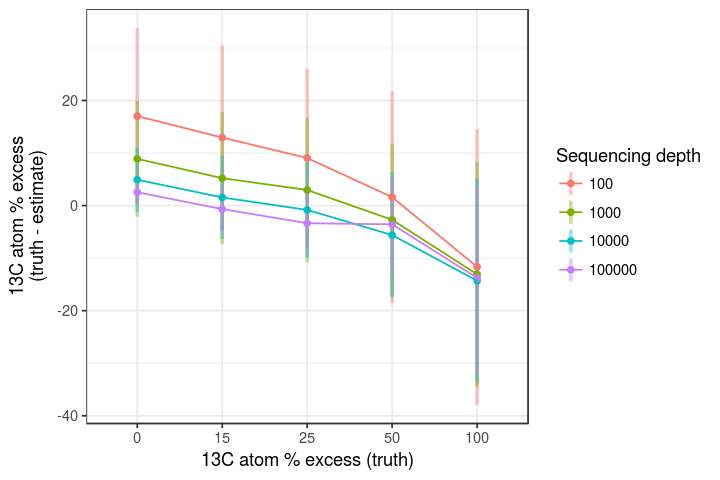

In [408]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=4)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=subsample_size, group=subsample_size,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('Sequencing depth') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

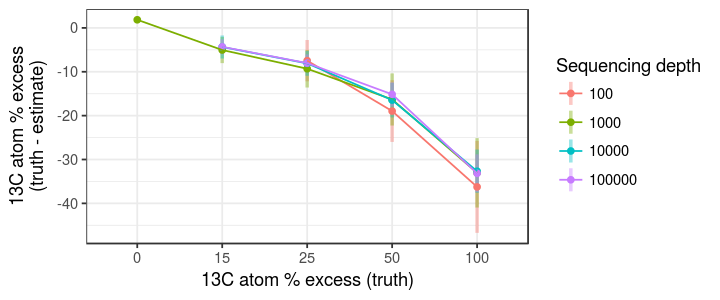

In [409]:
# difference between true and estimated

## q-SIP incorporators 
df.j.dis.qSIP = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric))
   
# plotting
options(repr.plot.width=6, repr.plot.height=2.5)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=subsample_size, group=subsample_size,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    geom_line() +
    #facet_grid(true_incorporator ~ .) +
    scale_color_discrete('Sequencing depth') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

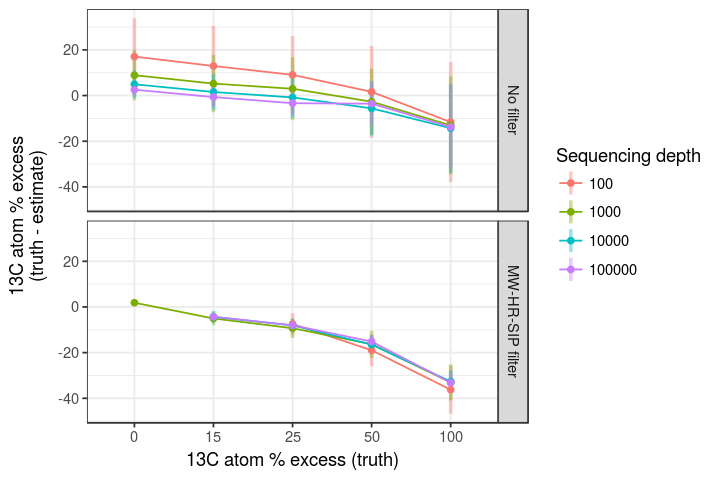

In [410]:
# difference between true and estimated
## q-SIP incorporators 
tmp1 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric),
           incorp_called = 'No filter')
## MW-HR-SIP incorporators
tmp2 = df.j %>%
    filter(atom_CI_low > 0) %>%     # just incorporators identified by q-SIP
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

# combining tables
df.j.dis.qSIP = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))

   
# plotting
options(repr.plot.width=6, repr.plot.height=4)
p_qSIP = ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=subsample_size, group=subsample_size,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('Sequencing depth') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_qSIP

## delta-BD

In [411]:
dBD_files = list.files(path=workDir, pattern='*_dBD.txt', full.names=TRUE, recursive=TRUE)
dBD_files %>% length %>% print

[1] 200


In [412]:
df_dBD = list()
for(F in dBD_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    FFl = length(FF)
    tmp$percIncorp = FF[FFl-3]
    tmp$subsample_size = FF[FFl-2]
    tmp$rep = FF[FFl-1]
    tmp$file = FF[FFl]
    df_dBD[[F]] = tmp
}

df_dBD = do.call(rbind, df_dBD)
rownames(df_dBD) = 1:nrow(df_dBD)
df_dBD %>% head(n=3) %>% print

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.711754          1.720307
2 Acetobacter_pasteurianus_IFO_3283-03        1.713130          1.702345
3       Acetobacterium_woodii_DSM_1030        1.710375          1.711485
  stdev_CM_control stdev_CM_treatment     delta_BD percIncorp subsample_size
1      0.025935581         0.02400887  0.008552586          0            100
2      0.003165968         0.02162307 -0.010784311          0            100
3      0.015119481         0.01750774  0.001110420          0            100
  rep                       file
1   1 OTU_abs1e9_PCR_sub_dBD.txt
2   1 OTU_abs1e9_PCR_sub_dBD.txt
3   1 OTU_abs1e9_PCR_sub_dBD.txt


### Joining estimate with truth

In [413]:
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'subsample_size'='subsample_size',
                                       'rep'='rep')) %>%
    filter(!is.na(delta_BD)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = delta_BD / 0.036)
df.j %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,percIncorp,subsample_size,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess
1,Acaryochloris_marina_MBIC11017,1.71175438596,1.72030697162,0.0259355808724,0.0240088669957,0.00855258565261,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.237571823683611
2,Acetobacter_pasteurianus_IFO_3283-03,1.71312974363,1.70234543255,0.00316596796691,0.021623066753,-0.0107843110873,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.299564196869444
3,Acetobacterium_woodii_DSM_1030,1.71037468492,1.71148510492,0.0151194808913,0.0175077401188,0.00111042000071,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.0308450000197222


### Joining with MW-HR-SIP

In [414]:
df.j = left_join(df.j, df_incorp, c('taxon' = 'taxon',
                                    'percIncorp'='percIncorp',
                                    'subsample_size'='subsample_size',
                                    'rep'='rep')) %>%
    mutate(HWHRSIP_incorp = ifelse(is.na(HWHRSIP_incorp), FALSE, TRUE))

df.j %>% nrow %>% print
df.j %>% head(n=3)

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

[1] 220400


,taxon,mean_CM_control,mean_CM_treatment,stdev_CM_control,stdev_CM_treatment,delta_BD,percIncorp,subsample_size,rep,file,median_true_BD_shift,true_incorporator,true_atom_fraction_excess,atom_fraction_excess,HWHRSIP_incorp
1,Acaryochloris_marina_MBIC11017,1.71175438596,1.72030697162,0.0259355808724,0.0240088669957,0.00855258565261,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.237571823683611,FALSE
2,Acetobacter_pasteurianus_IFO_3283-03,1.71312974363,1.70234543255,0.00316596796691,0.021623066753,-0.0107843110873,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,-0.299564196869444,FALSE
3,Acetobacterium_woodii_DSM_1030,1.71037468492,1.71148510492,0.0151194808913,0.0175077401188,0.00111042000071,0,100,1,OTU_abs1e9_PCR_sub_dBD.txt,0,FALSE,0,0.0308450000197222,FALSE


### Plotting results

Warning message:
“Removed 1 rows containing missing values (geom_linerange).”

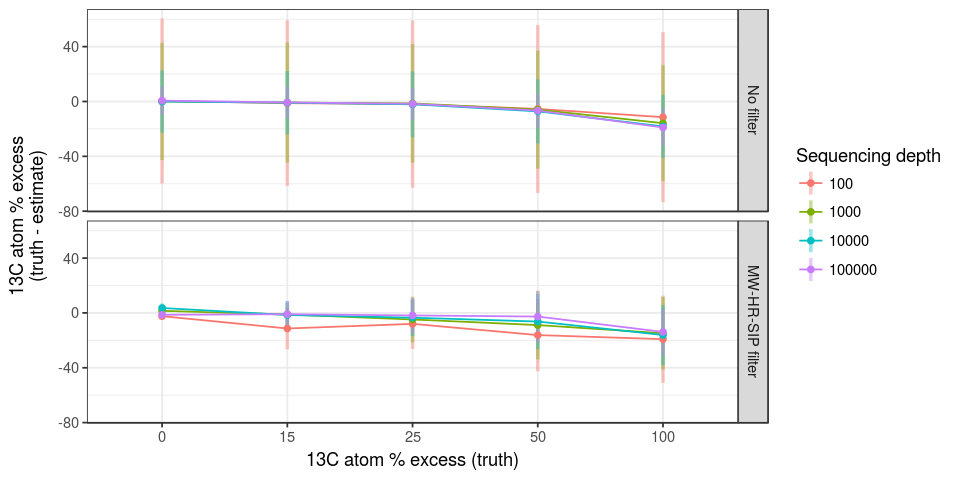

In [415]:
# difference between true and estimated
tmp1 = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric),
           incorp_called = 'No filter')

tmp2 = df.j %>%
    filter(HWHRSIP_incorp == TRUE) %>%    # just MW-HR-SIP incorporators 
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, subsample_size) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric),
           incorp_called = 'MW-HR-SIP filter')

   
# combining tables
df.j.dis.dBD = rbind(tmp1, tmp2) %>%
    mutate(incorp_called = factor(incorp_called, levels=c('No filter', 'MW-HR-SIP filter')))


# plotting
options(repr.plot.width=8, repr.plot.height=4)
p_dBD = ggplot(df.j.dis.dBD, aes(percIncorp, mean_delta_excess, 
                      color=subsample_size, group=subsample_size,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.4, size=1) +    
    geom_point() +
    facet_grid(incorp_called ~ .) +
    scale_color_discrete('Sequencing depth') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() 

p_dBD 

## Combined plot

Warning message:
“Removed 2 rows containing missing values (geom_linerange).”

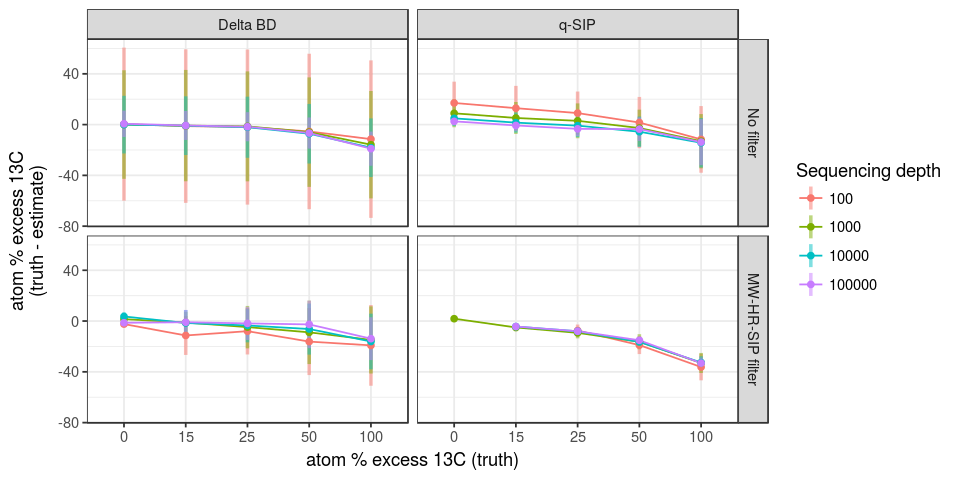

In [416]:
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='Delta BD')) %>%
    mutate(method = gsub('qSIP', 'q-SIP', method))


p.comb = ggplot(df.jj, aes(percIncorp, mean_delta_excess, 
                      color=subsample_size, group=subsample_size,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_line() +
    geom_linerange(alpha=0.5, size=1) +
    geom_point() +
    scale_color_discrete('Sequencing depth') +
    labs(x='atom % excess 13C (truth)', 
         y='atom % excess 13C\n(truth - estimate)') +
    facet_grid(incorp_called ~ method) +
    theme_bw() 
p.comb

In [417]:
outF = file.path(workDir, 'atomIncorp_sampDepth_BDshift.pdf')
ggsave(outF, p.comb, width=8, height=4)
cat('File written:', outF, '\n')

Warning message:
“Removed 2 rows containing missing values (geom_linerange).”

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//atomIncorp_sampDepth_BDshift.pdf 
